In [15]:
import pandas as pd
WORKSPACE = '/Users/houtonglei/OneDrive - stu.hqu.edu.cn/数学建模/2021美赛/'
DATASET_DESCRIPTION = WORKSPACE + '2021_ICM_ProblemC/2021MCM_ProblemC_DataSet.xlsx'

dataset_description = pd.read_excel(DATASET_DESCRIPTION)
dataset_description['Detection Date'] = dataset_description['Detection Date'].apply(lambda x:x.value/(10**9*3600*24))

In [16]:
import sklearn
import numpy as np
dataset_description = dataset_description.replace('Positive ID', 1)
dataset_description = dataset_description.replace('Negative ID', 0)
train_set = dataset_description[dataset_description['Lab Status'].isin([0, 1])]
train_dataset = sklearn.utils.Bunch()
train_dataset.data = train_set[['Detection Date', 'Latitude', 'Longitude']]
train_dataset.target = train_set['Lab Status']
train_dataset.target_names = ['neg', 'pos']
train_dataset.filenames = train_set['GlobalID']

In [17]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
x_train = std.fit_transform(train_dataset.data)
y_train = train_dataset.target.astype(np.int8)

In [18]:
"""from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_dataset.data, train_dataset.target, test_size=0.25)
x_train = std.fit_transform(x_train)
y_train = y_train.astype(np.int8)
x_val = std.transform(x_val)
y_val = y_val.astype(np.int8)"""

'from sklearn.model_selection import train_test_split\nx_train, x_val, y_train, y_val = train_test_split(train_dataset.data, train_dataset.target, test_size=0.25)\nx_train = std.fit_transform(x_train)\ny_train = y_train.astype(np.int8)\nx_val = std.transform(x_val)\ny_val = y_val.astype(np.int8)'

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
param_grid = {'alpha': 10.0**-np.arange(1,7), }
clf = GridSearchCV(SGDClassifier(max_iter=1000, tol=1e-3,loss='modified_huber',shuffle=True) , param_grid)
train_sizes,train_scores,test_scores,fit_times,score_times = learning_curve(clf,x_train, y_train, n_jobs=12, return_times=True)
clf.fit(x_train, y_train)

temp = clf.predict_proba(x_train)
clf.score(x_train, y_train)

0.9932756964457252

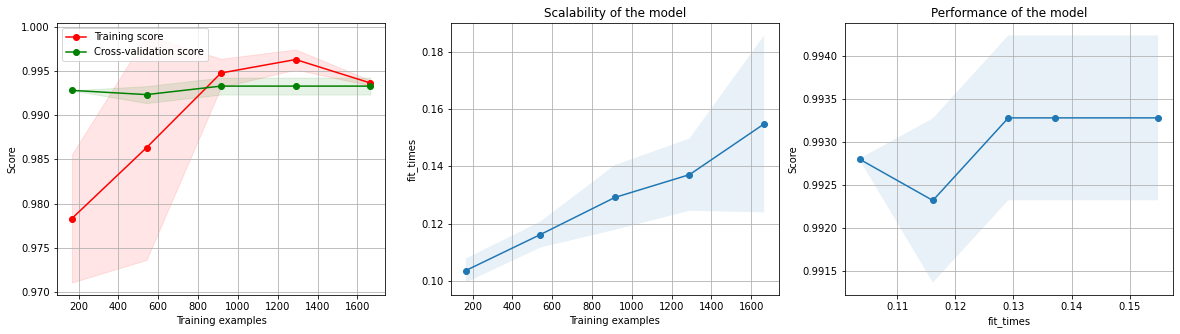

In [20]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
# Plot learning curve
axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

plt.show()
_.savefig('TL.svg',dpi=600)

In [21]:
"""print(clf.score(x_val, y_val))
print(clf.coef_)"""

'print(clf.score(x_val, y_val))\nprint(clf.coef_)'

In [22]:
train_proba = clf.predict_proba(train_dataset.data)
pd.DataFrame(train_proba,index=train_dataset.filenames.tolist(),columns=train_dataset.target_names).to_csv('result/t&l_embedding.csv', float_format='%.16f')

sum_file = pd.read_csv('result/sum_train.csv', index_col=0)
for i,p in enumerate(train_dataset.filenames.tolist()):
    sum_file.loc[p,'tl_pos'] = train_proba[i, 1]
sum_file.to_csv('result/sum_train.csv', float_format='%.16f')

In [23]:
test_set = dataset_description[dataset_description['Lab Status'].isin(['Unverified','Unprocessed'])]
test_dataset = sklearn.utils.Bunch()
test_dataset.data = test_set[['Detection Date', 'Latitude', 'Longitude']]
test_dataset.target = test_set['Lab Status']
test_dataset.target_names = ['Unknown']
test_dataset.filenames = test_set['GlobalID']

test_dataset.data = std.transform(test_dataset.data)

In [24]:
pred_proba = clf.predict_proba(test_dataset.data)
pd.DataFrame(pred_proba,index=test_dataset.filenames.tolist(),columns=train_dataset.target_names).to_csv('result/t&l_result.csv', float_format='%.16f')

sum_file = pd.read_csv('result/sum_test.csv', index_col=0)
for i,p in enumerate(test_dataset.filenames.tolist()):
    sum_file.loc[p,'tl_pos'] = pred_proba[i, 1]
sum_file.to_csv('result/sum_test.csv', float_format='%.16f')